In [1]:
import torch
import numpy as np
import ase.io
import tqdm

import sys
sys.path.append('../code/')
from code_pytorch import *
from utilities import *
from miscellaneous import ClebschGordan

from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
    
}

train_subset = '0:10000'
test_subset = '10000:11000'
DEVICE = 'cuda'
METHANE_PATH = '../methane.extxyz'
N_SPARSE = 100
clebsch = ClebschGordan(LAMBDA_MAX)

In [3]:
train_structures = ase.io.read(METHANE_PATH , index=train_subset)
test_structures = ase.io.read(METHANE_PATH , index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_coefs(train_structures, HYPERS, all_species)
test_coefficients = get_coefs(test_structures, HYPERS, all_species) 
L2_mean = get_L2_mean(train_coefficients)

for key in train_coefficients.keys():
    train_coefficients[key] /= torch.sqrt(L2_mean)
    test_coefficients[key] /= torch.sqrt(L2_mean)


train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

#train_energies = torch.FloatTensor(train_energies).to(DEVICE)
#test_energies = torch.FloatTensor(test_energies).to(DEVICE)


In [4]:
block = ClebschCombining(clebsch.precomputed_, 0)
#train_coefficients_n = L2_normalize(train_coefficients)
#test_coefficients_n = L2_normalize(test_coefficients)
train_ps = block(train_coefficients, train_coefficients)['0'].squeeze()
test_ps = block(test_coefficients, test_coefficients)['0'].squeeze()

sparse_ind = np.random.permutation(train_ps.shape[0])[0:N_SPARSE]
sparse_points = train_ps[sparse_ind]
print(sparse_points.shape)


torch.Size([100, 600])


In [5]:
def get_kernel(features, sparse_points):
    return torch.matmul(features, torch.transpose(sparse_points, 0, 1)) ** 2

In [6]:
train_kernel = get_kernel(train_ps, sparse_points)
test_kernel = get_kernel(test_ps, sparse_points)
#print([0:5])
accumulator = Accumulator()

train_kernel = accumulator({"kernel": train_kernel}, get_structural_indices(train_structures))['kernel']
test_kernel = accumulator({"kernel": test_kernel}, get_structural_indices(test_structures))['kernel']
print(train_kernel.shape)
print(test_kernel.shape)
#print(train_kernel[0:5])
regr = Ridge(alpha = 1e-10, fit_intercept = False)
regr.fit(train_kernel.data.cpu().numpy(), train_energies)
predictions = regr.predict(test_kernel.data.cpu().numpy())

torch.Size([10000, 100])
torch.Size([1000, 100])


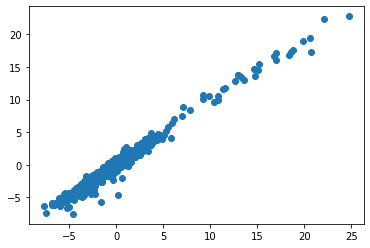

In [7]:
plt.plot(test_energies, predictions, 'o')
plt.show()

In [8]:
class KernelSingle(torch.nn.Module):
    def __init__(self, clebsch, sparse_points):
        super(KernelSingle, self).__init__()
        self.clebsch_combining = ClebschCombining(clebsch, 0)
        self.register_parameter('sparse_points', torch.nn.Parameter(sparse_points))
        self.linear = torch.nn.Linear(N_SPARSE, 1, bias = False)
        
    def forward(self, X):
        #X = L2_normalize(X)
        ps = self.clebsch_combining(X, X)['0'].squeeze()
        kernel_values = get_kernel(ps, self.sparse_points)
        return {'energies' : self.linear(kernel_values)}
    

In [9]:
block = KernelSingle(clebsch.precomputed_, sparse_points)
with torch.no_grad():
    block.linear.weight = torch.nn.Parameter(torch.from_numpy(regr.coef_).type(torch.get_default_dtype()))
    
atomic_energies = block(train_coefficients)
for key in atomic_energies.keys():
    print(key, atomic_energies[key].shape)

energies torch.Size([50000])


[  0   0   0 ... 999 999 999]
energies torch.Size([1000])


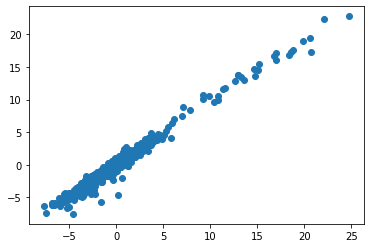

In [10]:
model = Atomistic(block)
test_struc_ind = get_structural_indices(test_structures)
print(test_struc_ind)
test_predictions = model(test_coefficients, structural_indices = test_struc_ind)
for key in test_predictions.keys():
    print(key, test_predictions[key].shape)
plt.plot(test_energies, test_predictions['energies'].data.cpu().numpy(), 'o')

# Forces

In [11]:
test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)
for key in coef_der_test.keys():
    coef_der_test[key] /= torch.sqrt(L2_mean)

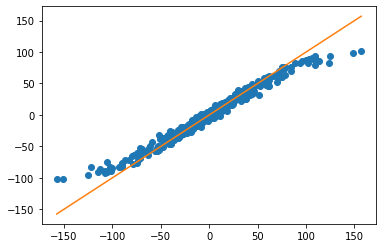

In [12]:
for key in test_coefficients.keys():
    test_coefficients[key].requires_grad = True
prediction_forces = model.get_forces(coef_der_test, central_indices_test, derivative_indices_test, 
                                         test_coefficients, structural_indices = test_struc_ind)
plt.plot(test_forces.reshape([-1]), prediction_forces.data.cpu().numpy().reshape([-1]), 'o')
min_f = np.min(test_forces)
max_f = np.max(test_forces)
plt.plot([min_f, max_f], [min_f, max_f])
plt.show()

# C++ invoke

In [24]:
test_central_species =  torch.IntTensor(get_central_species(test_structures))
test_structural_indices =  torch.IntTensor(get_structural_indices(test_structures))
traced = torch.jit.trace(model, [test_coefficients, test_central_species,
                                 test_structural_indices], strict = False)
traced.save("sparse_kernel_model_dict.pt")

In [25]:
class ListsWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ListsWrapper, self).__init__()
        self.model = model
        
    def forward(self, *X):
        coefs = {}
        for lambd in range(LAMBDA_MAX + 1):
            coefs[lambd] = X[lambd]
        central_ind = X[LAMBDA_MAX + 1]
        struc_ind = X[LAMBDA_MAX + 2]
        result = model(coefs, central_ind, struc_ind)
        return result['energies']

In [28]:
model_list = ListsWrapper(model)
inputs = []
for lambd in range(LAMBDA_MAX + 1):
    inputs.append(test_coefficients[lambd])
inputs.append(test_central_species)
inputs.append(test_structural_indices)
result = model_list(*inputs)
print(result[0:10])

tensor([-2.2262, -3.0381, -1.2729,  0.6249, -3.1689, -1.8544,  1.5321,  1.6077,
         0.5077, -1.5478], grad_fn=<SliceBackward>)


In [29]:
traced = torch.jit.trace(model_list, inputs, strict = False)
traced.save("sparse_kernel_model_list.pt")

In [30]:
coef_small = {}
for key in test_coefficients.keys():
    coef_small[key] = test_coefficients[key][0:10]
struc_ind_small = torch.IntTensor(get_structural_indices(test_structures)[0:10])
central_species_small = torch.IntTensor(get_central_species(test_structures)[0:10])

inputs_small = []
for lambd in range(LAMBDA_MAX + 1):
    inputs_small.append(coef_small[lambd])
inputs_small.append(central_species_small)
inputs_small.append(struc_ind_small)

In [31]:
for i in tqdm.tqdm(range(len(inputs))):
    shape_now = inputs[i].shape
    now = inputs[i].reshape(-1)
    with open("inputs/{}".format(i), "w") as f:
        print(len(shape_now), file = f)
        for dim in shape_now:
            print(dim, file = f, end = ' ')
        print(file = f)
        for j in range(now.shape[0]):
            print(now[j].item(), file = f, end = ' ')
    

100%|██████████| 8/8 [00:03<00:00,  2.54it/s]
